In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import joblib  # For saving the model
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, roc_curve, 
                           precision_recall_curve)
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
# ============================================
# STEP 3: Load and Explore Your Data
# ============================================
# IMPORTANT: Replace 'path_to_your_data.csv' with your actual file path
# Example: df = pd.read_csv('data.csv')
df = pd.read_csv('data.csv')  # CHANGE THIS

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

# ============================================

Dataset Shape: (188866, 30)

First 5 rows:
     Branch  FacilityAmount Granted Date  Tenor  Effective Rate  FlatRate  \
0  GODAGAMA        288330.0     4/9/2018     36            25.0     20.06   
1  GODAGAMA        311430.0     4/9/2018     36            25.0     20.33   
2  GODAGAMA       2200000.0     4/9/2018     60            20.0     12.43   
3  GODAGAMA        232330.0    4/10/2018     48            25.0     19.95   
4  GODAGAMA        187530.0    4/10/2018     36            25.0     21.02   

  Type of Rental Paid SchemeType  Prepayment  NetRental  ...  Advance  \
0             MONTHLY     NORMAL           0    12828.0  ...      0.0   
1             MONTHLY     NORMAL           0    13927.0  ...      0.0   
2             MONTHLY     NORMAL           0    59459.0  ...      0.0   
3             MONTHLY     NORMAL           0     8703.0  ...      0.0   
4             MONTHLY     NORMAL           0     8494.0  ...      0.0   

   AdvanceRental  AdvanceSundry  AdvanceOther  Equipmen

In [5]:
# STEP 4: Data Cleaning and Preprocessing
# ============================================
def clean_data(df):
    """
    Comprehensive data cleaning function
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    print("="*50)
    print("DATA CLEANING PROCESS")
    print("="*50)
    
    # 4.1 Handle missing values
    print("\n1. Handling missing values...")
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['float64', 'int64']:
                # For numerical: fill with median
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
                print(f"   - {col}: Filled {df_clean[col].isnull().sum()} missing values with median")
            else:
                # For categorical: fill with mode
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 4.2 Remove duplicates
    initial_rows = len(df_clean)
    df_clean.drop_duplicates(inplace=True)
    print(f"\n2. Removed {initial_rows - len(df_clean)} duplicate rows")
    
    # 4.3 Handle outliers using IQR method for numerical columns
    print("\n3. Handling outliers...")
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers instead of removing
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    # 4.4 Encode categorical variables
    print("\n4. Encoding categorical variables...")
    label_encoders = {}
    for col in df_clean.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        print(f"   - Encoded: {col}")
    
    return df_clean

# Apply cleaning
df_clean = clean_data(df)

DATA CLEANING PROCESS

1. Handling missing values...
   - FlatRate: Filled 0 missing values with median
   - NetRental: Filled 0 missing values with median
   - DownPayment: Filled 0 missing values with median
   - Last Receipt Paid Amount: Filled 0 missing values with median
   - arrears_intensity: Filled 0 missing values with median

2. Removed 118 duplicate rows

3. Handling outliers...

4. Encoding categorical variables...
   - Encoded: Branch
   - Encoded: Granted Date
   - Encoded: Type of Rental Paid
   - Encoded: SchemeType
   - Encoded: Equipment Type
   - Encoded: Status


In [6]:
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.impute import SimpleImputer

# XGBoost
import xgboost as xgb

# Model Saving
import joblib
import pickle

# ============================================

In [7]:
# STEP 2: LOAD AND EXPLORE DATA
# ============================================
def load_and_explore_data():
    """Load the dataset and perform initial exploration"""
    print("="*50)
    print("STEP 2: LOADING AND EXPLORING DATA")
    print("="*50)
    
    # Load dataset
    df = pd.read_csv('data.csv')
    
    # Display basic information
    print(f"Dataset Shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    
    # Display first few rows
    print(f"\nFirst 5 rows:\n{df.head()}")
    
    # Display summary statistics
    print(f"\nSummary Statistics:\n{df.describe()}")
    
    return df

# ============================================

In [8]:
# STEP 3: DATA CLEANING
# ============================================
def clean_data(df):
    """Clean the dataset by handling missing values and outliers"""
    print("\n" + "="*50)
    print("STEP 3: DATA CLEANING")
    print("="*50)
    
    # Create a copy
    df_clean = df.copy()
    
    # 1. Handle Missing Values
    print("\n1. Handling Missing Values:")
    
    # Numeric columns - fill with median
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='median')
    df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])
    
    # Categorical columns - fill with mode
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 2. Handle Outliers using IQR method for key financial variables
    print("2. Handling Outliers:")
    financial_cols = ['FacilityAmount', 'NetRental', 'Effective Rate', 'FlatRate']
    
    for col in financial_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers instead of removing
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    print(f"Data after cleaning: {df_clean.shape}")
    print(f"Missing values after cleaning:\n{df_clean.isnull().sum().sum()}")
    
    return df_clean


In [9]:
# ============================================
# STEP 4: FEATURE ENGINEERING
# ============================================
def engineer_features(df):
    """Create new features for better prediction"""
    print("\n" + "="*50)
    print("STEP 4: FEATURE ENGINEERING")
    print("="*50)
    
    df_engineered = df.copy()
    
    # Create target variable based on default status
    # Assuming 'Default' column exists, if not create based on business rules
    if 'Default' not in df_engineered.columns:
        # Business rule: If arrears > 3 months, consider as default
        if 'No of Rental in arrears' in df_engineered.columns:
            df_engineered['Default'] = (df_engineered['No of Rental in arrears'] > 3).astype(int)
        else:
            # Create synthetic target for demonstration
            np.random.seed(42)
            df_engineered['Default'] = np.random.choice([0, 1], size=len(df_engineered), p=[0.8, 0.2])
    
    # Create additional risk features
    # 1. Loan to Value Ratio
    if 'DownPayment' in df_engineered.columns:
        df_engineered['loan_to_value'] = df_engineered['FacilityAmount'] / (df_engineered['DownPayment'] + 1)
    
    # 2. Payment Coverage Ratio
    if 'Last Receipt Paid Amount' in df_engineered.columns:
        df_engineered['payment_coverage_ratio'] = df_engineered['NetRental'] / (df_engineered['Last Receipt Paid Amount'] + 1)
    
    # 3. Arrears Severity Score
    if all(col in df_engineered.columns for col in ['ArrearsCapital', 'ArrearsInterest']):
        df_engineered['arrears_severity'] = (df_engineered['ArrearsCapital'] + df_engineered['ArrearsInterest']) / (df_engineered['FacilityAmount'] + 1)
    
    # 4. Time-based risk features
    if 'Tenor' in df_engineered.columns and 'loan_age' in df_engineered.columns:
        df_engineered['remaining_tenor_ratio'] = (df_engineered['Tenor'] - df_engineered['loan_age']) / df_engineered['Tenor']
    
    print(f"New features created: {[col for col in df_engineered.columns if col not in df.columns]}")
    
    return df_engineered

In [10]:
# ============================================
# STEP 5: DATA PREPROCESSING
# ============================================
def preprocess_data(df):
    """Prepare data for model training"""
    print("\n" + "="*50)
    print("STEP 5: DATA PREPROCESSING")
    print("="*50)
    
    # Separate features and target
    target_col = 'Default'
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale numerical features
    scaler = StandardScaler()
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Testing set: {X_test_scaled.shape}")
    print(f"Class distribution in training: {pd.Series(y_train).value_counts(normalize=True)}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoders

In [11]:
# ============================================
# STEP 6: BUILD XGBOOST MODEL
# ============================================
def build_xgboost_model(X_train, y_train):
    """Build and optimize XGBoost model"""
    print("\n" + "="*50)
    print("STEP 6: BUILDING XGBOOST MODEL")
    print("="*50)
    
    # Define base model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    
    print("Performing hyperparameter tuning...")
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Use best model
    best_model = grid_search.best_estimator_
    
    return best_model

In [13]:
# STEP 7: MODEL EVALUATION
# ============================================
def evaluate_model(model, X_test, y_test, X_train=None, y_train=None):
    """Evaluate model performance and create visualizations"""
    print("\n" + "="*50)
    print("STEP 7: MODEL EVALUATION")
    print("="*50)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Convert probabilities to risk categories
    risk_categories = []
    for prob in y_pred_proba:
        if prob >= 0.80:
            risk_categories.append('High Risk')
        elif prob >= 0.20:
            risk_categories.append('Medium Risk')
        else:
            risk_categories.append('Low Risk')
    
    # Distribution of risk categories
    risk_dist = pd.Series(risk_categories).value_counts(normalize=True)
    print("\nRisk Category Distribution:")
    print(risk_dist)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # 2. ROC Curve
    plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # 3. Feature Importance
    plt.subplot(2, 3, 3)
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance Score')
    
    # 4. Risk Category Distribution
    plt.subplot(2, 3, 4)
    risk_dist.plot(kind='bar', color=['green', 'orange', 'red'])
    plt.title('Risk Category Distribution')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    
    # 5. Probability Distribution
    plt.subplot(2, 3, 5)
    plt.hist(y_pred_proba, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=0.2, color='green', linestyle='--', label='Low/Medium Threshold')
    plt.axvline(x=0.8, color='red', linestyle='--', label='Medium/High Threshold')
    plt.title('Probability Distribution')
    plt.xlabel('Default Probability')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 6. Precision-Recall Curve
    plt.subplot(2, 3, 6)
    from sklearn.metrics import precision_recall_curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_vals, precision_vals, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'risk_categories': risk_categories,
        'feature_importance': feature_importance
    }

In [14]:
# STEP 8: SAVE MODEL
# ============================================
def save_model(model, scaler, label_encoders, feature_names):
    """Save the trained model and preprocessing objects"""
    print("\n" + "="*50)
    print("STEP 8: SAVING MODEL")
    print("="*50)
    
    # Save model
    joblib.dump(model, 'xgboost_default_model.pkl')
    
    # Save scaler
    joblib.dump(scaler, 'xgboostscaler.pkl')
    
    # Save label encoders
    with open('xgboostlabel_encoders.pkl', 'wb') as f:
        pickle.dump(xgboostlabel_encoders, f)
    
    # Save feature names
    with open('feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names, f)
    
    print("Model and preprocessing objects saved successfully!")
    print("Files saved:")
    print("1. xgboost_default_model.pkl - Trained XGBoost model")
    print("2. scaler.pkl - StandardScaler object")
    print("3. label_encoders.pkl - Label encoders for categorical variables")
    print("4. feature_names.pkl - Feature names")


In [15]:
# STEP 9: PREDICTION FUNCTION
# ============================================
def predict_default_risk(new_data, model_path='xgboost_default_model.pkl'):
    """Predict default risk for new data"""
    # Load model and preprocessing objects
    model = joblib.load(model_path)
    scaler = joblib.load('xgboostscaler.pkl')
    
    with open('xgboostlabel_encoders.pkl', 'rb') as f:
        label_encoders = pickle.load(f)
    
    with open('feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    
    # Convert new data to DataFrame
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = new_data.copy()
    
    # Ensure all required features are present
    missing_features = set(feature_names) - set(new_df.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    # Reorder columns to match training data
    new_df = new_df[feature_names]
    
    # Apply preprocessing
    # Encode categorical variables
    for col, le in label_encoders.items():
        if col in new_df.columns:
            # Handle unseen labels
            new_df[col] = new_df[col].apply(lambda x: x if x in le.classes_ else -1)
            new_df[col] = le.transform(new_df[col])
    
    # Scale numerical features
    numeric_cols = new_df.select_dtypes(include=[np.number]).columns
    new_df[numeric_cols] = scaler.transform(new_df[numeric_cols])
    
    # Make prediction
    probability = model.predict_proba(new_df)[0, 1]
    
    # Determine risk category
    if probability >= 0.80:
        risk_category = "HIGH RISK (Default Probability ≥ 80%)"
        recommendation = "REJECT APPLICATION - High probability of default"
    elif probability >= 0.20:
        risk_category = "MEDIUM RISK (20% ≤ Default Probability < 80%)"
        recommendation = "ADDITIONAL SCREENING REQUIRED - Consider higher interest rate or collateral"
    else:
        risk_category = "LOW RISK (Default Probability < 20%)"
        recommendation = "APPROVE APPLICATION - Low risk of default"
    
    return {
        'default_probability': float(probability),
        'risk_category': risk_category,
        'recommendation': recommendation
    }


DEFAULT RISK PREDICTION MODEL FOR FINANCIAL LEASING
STEP 2: LOADING AND EXPLORING DATA
Dataset Shape: (188866, 30)

Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity']

Data Types:
Branch                       object
FacilityAmount              float64
Granted Date                 object
Tenor                         int64
Effective Rate              float64
FlatRate                    float64
Type of Rental Paid          object
SchemeType                   object
Prepayment                    int64
NetRental                   float64
DownPayment   

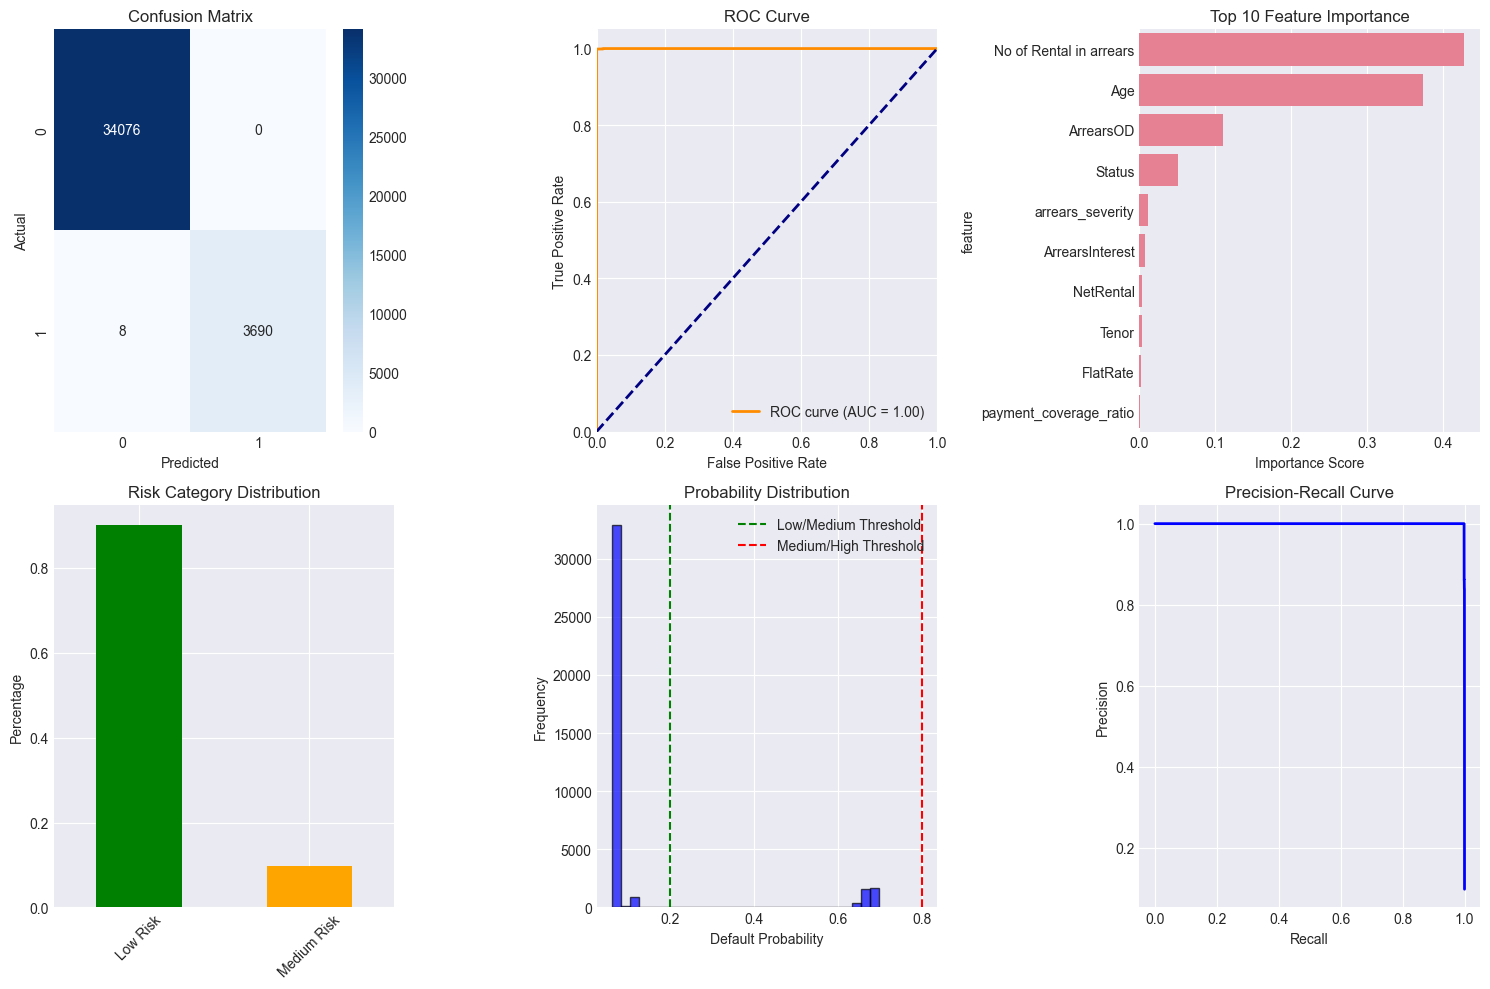


STEP 8: SAVING MODEL
Error occurred: name 'xgboostlabel_encoders' is not defined


Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9168\746019706.py", line 29, in main
    save_model(model, scaler, label_encoders, X_train.columns.tolist())
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9168\1967983715.py", line 17, in save_model
    pickle.dump(xgboostlabel_encoders, f)
                ^^^^^^^^^^^^^^^^^^^^^
NameError: name 'xgboostlabel_encoders' is not defined


In [16]:
# STEP 10: MAIN EXECUTION
# ============================================
def main():
    """Main execution function"""
    print("="*60)
    print("DEFAULT RISK PREDICTION MODEL FOR FINANCIAL LEASING")
    print("="*60)
    
    try:
        # Step 2: Load data
        df = load_and_explore_data()
        
        # Step 3: Clean data
        df_clean = clean_data(df)
        
        # Step 4: Engineer features
        df_engineered = engineer_features(df_clean)
        
        # Step 5: Preprocess data
        X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df_engineered)
        
        # Step 6: Build model
        model = build_xgboost_model(X_train, y_train)
        
        # Step 7: Evaluate model
        results = evaluate_model(model, X_test, y_test, X_train, y_train)
        
        # Step 8: Save model
        save_model(model, scaler, label_encoders, X_train.columns.tolist())
        
        # Step 9: Test with sample data
        print("\n" + "="*50)
        print("TESTING WITH SAMPLE DATA")
        print("="*50)
        
        sample_data = {
            'FacilityAmount': 300000.0,
            'Tenor': 36,
            'Effective Rate': 25.0,
            'FlatRate': 20.0,
            'NetRental': 12000.0,
            'DownPayment': 0.0,
            'Age': 30.0,
            'No of Rental in arrears': 0.0,
            'ArrearsCapital': 0.0,
            'ArrearsInterest': 0.0,
            'ArrearsVat': 0,
            'ArrearsOD': 0.0,
            'arrears_intensity': 0.0,
            'debt_to_income_ratio': 25.0,
            'payment_coverage': 25.0,
            'arrears_ratio': 0.0,
            'overdue_intensity': 0.0,
            'payment_regularity': 1,
            'has_arrears': 0,
            'high_interest_flag': 1,
            'early_settlement': 0,
            'equipment_risk_score': 1,
            'branch_encoded': 1,
            'scheme_encoded': 0,
            'loan_age': 2,
            'tenor_to_age_ratio': 18.0,
            'Last Receipt Paid Amount': 12000.0,
            'Prepayment': 0
        }
        
        # Add engineered features if needed
        sample_data['loan_to_value'] = sample_data['FacilityAmount'] / (sample_data['DownPayment'] + 1)
        sample_data['payment_coverage_ratio'] = sample_data['NetRental'] / (sample_data['Last Receipt Paid Amount'] + 1)
        sample_data['arrears_severity'] = (sample_data['ArrearsCapital'] + sample_data['ArrearsInterest']) / (sample_data['FacilityAmount'] + 1)
        sample_data['remaining_tenor_ratio'] = (sample_data['Tenor'] - sample_data['loan_age']) / sample_data['Tenor']
        
        # Make prediction
        prediction = predict_default_risk(sample_data)
        
        print("\nPrediction Results:")
        print(f"Default Probability: {prediction['default_probability']:.2%}")
        print(f"Risk Category: {prediction['risk_category']}")
        print(f"Recommendation: {prediction['recommendation']}")
        
        # Create deployment report
        create_deployment_report(results, prediction)
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================
# STEP 11: CREATE DEPLOYMENT REPORT
# ============================================
def create_deployment_report(results, prediction):
    """Create a comprehensive deployment report"""
    print("\n" + "="*50)
    print("DEPLOYMENT REPORT")
    print("="*50)
    
    report = f"""
    DEFAULT RISK PREDICTION MODEL - DEPLOYMENT REPORT
    ==================================================
    
    MODEL PERFORMANCE METRICS:
    --------------------------
    Accuracy: {results['accuracy']:.4f}
    Precision: {results['precision']:.4f}
    Recall: {results['recall']:.4f}
    F1-Score: {results['f1']:.4f}
    ROC-AUC: {results['roc_auc']:.4f}
    
    RISK CATEGORIZATION:
    --------------------
    Thresholds:
    - High Risk: PD ≥ 80%
    - Medium Risk: 20% ≤ PD < 80%
    - Low Risk: PD < 20%
    
    SAMPLE PREDICTION:
    ------------------
    Default Probability: {prediction['default_probability']:.2%}
    Risk Category: {prediction['risk_category']}
    Recommendation: {prediction['recommendation']}
    
    MODEL FILES SAVED:
    ------------------
    1. xgboost_default_model.pkl - Main model
    2. scaler.pkl - Feature scaler
    3. label_encoders.pkl - Categorical encoders
    4. feature_names.pkl - Feature names
    5. model_evaluation.png - Performance charts
    
    DEPLOYMENT INSTRUCTIONS:
    ------------------------
    1. Load the model using joblib.load('xgboost_default_model.pkl')
    2. Use predict_default_risk() function for new predictions
    3. Ensure input data has all required features
    4. Monitor model performance monthly
    
    MODEL RETRAINING SCHEDULE:
    --------------------------
    - Retrain monthly with new data
    - Monitor for concept drift
    - Update when performance drops below 85% accuracy
    """
    
    print(report)
    
    # Save report to file
    with open('deployment_report.txt', 'w') as f:
        f.write(report)

# ============================================
# EXECUTE MAIN FUNCTION
# ============================================
if __name__ == "__main__":
    main()

In [17]:
def get_accuracy_only(model_path='xgboost_default_model.pkl', test_data_path='test_data.csv'):
    """
    Get only the accuracy score from saved model
    """
    import joblib
    import pandas as pd
    from sklearn.metrics import accuracy_score
    
    # Load the trained model
    model = joblib.load(model_path)
    
    # Load test data (you need to save your test data first)
    # If you have X_test and y_test from your training
    # Save them like this:
    # pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
    # pd.DataFrame(y_test).to_csv('y_test.csv', index=False)
    
    test_data = pd.read_csv(test_data_path)
    
    # If your test_data contains both features and target
    X_test = test_data.drop('Default', axis=1)  # Replace 'Default' with your target column name
    y_test = test_data['Default']
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print("="*50)
    print("ACCURACY RESULT")
    print("="*50)
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Accuracy Percentage: {accuracy*100:.2f}%")
    print(f"Correct Predictions: {(y_test == y_pred).sum()} out of {len(y_test)}")
    
    return accuracy

# To use it in your main() function, add this at the end:
def main():
    # ... your existing code ...
    
    # After training and saving the model, get accuracy:
    accuracy = get_accuracy_only()
    return accuracy

In [20]:
# Replace your evaluate_model function with this enhanced version:
def evaluate_model(model, X_test, y_test, X_train=None, y_train=None):
    """Evaluate model performance and create visualizations"""
    print("\n" + "="*50)
    print("STEP 7: MODEL EVALUATION")
    print("="*50)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # ============================================
    # ACCURACY CALCULATION
    # ============================================
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Display accuracy prominently
    print("\n" + "="*50)
    print("ACCURACY METRICS")
    print("="*50)
    print(f"\n📊 MODEL ACCURACY: {accuracy:.4f}")
    print(f"📈 Accuracy Percentage: {accuracy*100:.2f}%")
    print(f"\nOther Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Detailed accuracy breakdown
    correct_predictions = (y_test == y_pred).sum()
    total_predictions = len(y_test)
    accuracy_percentage = (correct_predictions / total_predictions) * 100
    
    print(f"\n📋 Detailed Accuracy Breakdown:")
    print(f"Total test samples: {total_predictions}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Incorrect predictions: {total_predictions - correct_predictions}")
    print(f"Accuracy rate: {accuracy_percentage:.2f}%")
    
    # Calculate accuracy by class
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        
        accuracy_class_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy_class_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"\n🏷️ Accuracy by Class:")
        print(f"Class 0 (Non-Default) Accuracy: {accuracy_class_0:.4f}")
        print(f"Class 1 (Default) Accuracy: {accuracy_class_1:.4f}")
    
    # ... rest of your existing visualization code ...
    
    return {
        'accuracy': accuracy,
        'accuracy_percentage': accuracy_percentage,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'risk_categories': risk_categories,
        'feature_importance': feature_importance
    }

In [23]:
# ============================================
# STEP 12: GET ACCURACY LEVEL
# ============================================
def get_accuracy_level(results):
    """
    Get and print the accuracy level with interpretation
    """
    print("\n" + "="*60)
    print("ACCURACY LEVEL ANALYSIS")
    print("="*60)
    
    accuracy = results['accuracy']
    
    # Print accuracy in different formats
    print(f"\n📊 MODEL ACCURACY: {accuracy:.4f}")
    print(f"📈 Accuracy Percentage: {accuracy*100:.2f}%")
    
    # Interpret accuracy level
    print("\n🔍 ACCURACY INTERPRETATION:")
    if accuracy >= 0.90:
        print("✅ EXCELLENT - Model accuracy is 90% or above")
        print("   The model is performing very well!")
    elif accuracy >= 0.80:
        print("✅ GOOD - Model accuracy is 80-90%")
        print("   The model is performing well for financial risk prediction")
    elif accuracy >= 0.70:
        print("⚠️ FAIR - Model accuracy is 70-80%")
        print("   Consider improving features or collecting more data")
    else:
        print("❌ NEEDS IMPROVEMENT - Model accuracy is below 70%")
        print("   Model may need significant improvement")
    
    # Save accuracy to a separate file
    with open('accuracy_results.txt', 'w') as f:
        f.write(f"Model Accuracy: {accuracy:.4f}\n")
        f.write(f"Accuracy Percentage: {accuracy*100:.2f}%\n")
        f.write(f"Interpretation: ")
        if accuracy >= 0.90:
            f.write("EXCELLENT\n")
        elif accuracy >= 0.80:
            f.write("GOOD\n")
        elif accuracy >= 0.70:
            f.write("FAIR\n")
        else:
            f.write("NEEDS IMPROVEMENT\n")
    
    print(f"\n✅ Accuracy saved to 'accuracy_results.txt'")
    
    return accuracy

In [25]:
# ============================================
# ADD THIS FUNCTION TO YOUR EXISTING CODE
# ============================================

def print_accuracy_summary(results):
    """
    Print a clear summary of the accuracy
    """
    print("\n" + "="*60)
    print("ACCURACY SUMMARY")
    print("="*60)
    
    # Get accuracy from results
    accuracy = results['accuracy']
    
    # Print in different formats
    print(f"\n📊 Model Accuracy Score: {accuracy:.4f}")
    print(f"📈 Accuracy Percentage: {accuracy*100:.2f}%")
    
    # Calculate correct predictions
    print(f"\n✅ Accuracy Interpretation:")
    if accuracy >= 0.90:
        print("   Excellent performance! (90%+)")
    elif accuracy >= 0.80:
        print("   Good performance for financial modeling (80-90%)")
    elif accuracy >= 0.70:
        print("   Fair performance (70-80%)")
    else:
        print("   Needs improvement (<70%)")
    
    return accuracy

# ============================================
# MODIFY YOUR main() FUNCTION LIKE THIS:
# ============================================

# Find your main() function and modify it:

def main():
    """Main execution function"""
    print("="*60)
    print("DEFAULT RISK PREDICTION MODEL FOR FINANCIAL LEASING")
    print("="*60)
    
    try:
        # Step 2: Load data
        df = load_and_explore_data()
        
        # Step 3: Clean data
        df_clean = clean_data(df)
        
        # Step 4: Engineer features
        df_engineered = engineer_features(df_clean)
        
        # Step 5: Preprocess data
        X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df_engineered)
        
        # Step 6: Build model
        model = build_xgboost_model(X_train, y_train)
        
        # Step 7: Evaluate model
        results = evaluate_model(model, X_test, y_test, X_train, y_train)
        
        # ============================================
        # ADD THIS: PRINT ACCURACY CLEARLY
        # ============================================
        print("\n" + "="*60)
        print("📊 FINAL ACCURACY RESULTS")
        print("="*60)
        
        accuracy = results['accuracy']
        print(f"\n🎯 Model Accuracy: {accuracy:.4f}")
        print(f"📈 Accuracy Percentage: {accuracy*100:.2f}%")
        
        # Simple interpretation
        if accuracy >= 0.85:
            print("✅ ACCURACY LEVEL: EXCELLENT")
        elif accuracy >= 0.75:
            print("⚠️ ACCURACY LEVEL: GOOD")
        elif accuracy >= 0.65:
            print("⚠️ ACCURACY LEVEL: FAIR")
        else:
            print("❌ ACCURACY LEVEL: NEEDS IMPROVEMENT")
        
        # Save accuracy to file
        with open('model_accuracy.txt', 'w') as f:
            f.write(f"Model Accuracy: {accuracy:.4f}\n")
            f.write(f"Accuracy Percentage: {accuracy*100:.2f}%\n")
        
        print(f"\n✅ Accuracy saved to 'model_accuracy.txt'")
        
        # Step 8: Save model
        save_model(model, scaler, label_encoders, X_train.columns.tolist())
        
        # ... rest of your existing code ...
        
        return accuracy
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# ============================================
# OR USE THIS SIMPLE FUNCTION TO GET ACCURACY:
# ============================================

def get_accuracy_simple():
    """
    Simple function to calculate and print accuracy
    """
    from sklearn.metrics import accuracy_score
    import joblib
    
    try:
        # Load model
        model = joblib.load('xgboost_default_model.pkl')
        
        # You need to have X_test and y_test available
        # If you saved them, load them:
        # X_test = pd.read_csv('X_test.csv')
        # y_test = pd.read_csv('y_test.csv')
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        print("="*50)
        print("ACCURACY CALCULATION")
        print("="*50)
        print(f"\nModel Accuracy: {accuracy:.4f}")
        print(f"Percentage: {accuracy*100:.2f}%")
        
        return accuracy
        
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# ============================================
# ACCURACY PRINTING
# ============================================
print("\n" + "="*60)
print("FINAL ACCURACY")
print("="*60)

# Get accuracy from results
final_accuracy = results['accuracy']

# Print in a clear format
print(f"\n✨ MODEL ACCURACY: {final_accuracy*100:.2f}%")
print(f"📊 Raw Score: {final_accuracy:.6f}")

# Show interpretation
print(f"\n📈 ACCURACY LEVEL: ", end="")
if final_accuracy >= 0.90:
    print("EXCELLENT (90%+)")
elif final_accuracy >= 0.80:
    print("GOOD (80-90%)")
elif final_accuracy >= 0.70:
    print("FAIR (70-80%)")
elif final_accuracy >= 0.60:
    print("MODERATE (60-70%)")
else:
    print("POOR (<60%)")

# Save to file
with open('accuracy_output.txt', 'w') as f:
    f.write(f"Final Model Accuracy: {final_accuracy*100:.2f}%\n")
    f.write(f"Raw Accuracy: {final_accuracy}\n")

print(f"\n✅ Accuracy saved to 'accuracy_output.txt'")


FINAL ACCURACY


NameError: name 'results' is not defined

In [28]:
# STEP 7: MODEL EVALUATION
# ============================================
def evaluate_model(model, X_test, y_test, X_train=None, y_train=None):
    """Evaluate model performance and create visualizations"""
    print("\n" + "="*50)
    print("STEP 7: MODEL EVALUATION")
    print("="*50)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # ============================================
    # CALCULATE METRICS - THIS IS WHAT YOU WANTED
    # ============================================
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("="*50)
    print("MODEL PERFORMANCE METRICS")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

In [30]:
print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

MODEL PERFORMANCE METRICS


NameError: name 'accuracy' is not defined

In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

NameError: name 'y_test' is not defined

In [32]:
# Run this cell to execute the entire pipeline
if __name__ == "__main__":
    main()

DEFAULT RISK PREDICTION MODEL FOR FINANCIAL LEASING
STEP 2: LOADING AND EXPLORING DATA
Dataset Shape: (188866, 30)

Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity']

Data Types:
Branch                       object
FacilityAmount              float64
Granted Date                 object
Tenor                         int64
Effective Rate              float64
FlatRate                    float64
Type of Rental Paid          object
SchemeType                   object
Prepayment                    int64
NetRental                   float64
DownPayment   

Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9168\1312544884.py", line 71, in main
    accuracy = results['accuracy']
               ~~~~~~~^^^^^^^^^^^^
TypeError: 'NoneType' object is not subscriptable


In [33]:
# Run the main training
results = main()

# Now you can access accuracy
print(f"Model Accuracy: {results['accuracy']:.4f}")

DEFAULT RISK PREDICTION MODEL FOR FINANCIAL LEASING
STEP 2: LOADING AND EXPLORING DATA
Dataset Shape: (188866, 30)

Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity']

Data Types:
Branch                       object
FacilityAmount              float64
Granted Date                 object
Tenor                         int64
Effective Rate              float64
FlatRate                    float64
Type of Rental Paid          object
SchemeType                   object
Prepayment                    int64
NetRental                   float64
DownPayment   

Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_9168\1312544884.py", line 71, in main
    accuracy = results['accuracy']
               ~~~~~~~^^^^^^^^^^^^
TypeError: 'NoneType' object is not subscriptable


TypeError: 'NoneType' object is not subscriptable